In [7]:
# Bhavesh Chowdary : CS22BTECH11041
# Paavaneeswar : CS22BTECH11014
# Gufran : CS22BTECH11040

import torch
from torch import nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler

# Setting random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Load the data
data = pd.read_csv('data.csv')

# Data preprocessing
print("Original data shape:", data.shape)
print("Data columns:", data.columns.tolist())
print("First few rows:")
print(data.head())

# Check for missing values
print("\nMissing values:")
print(data.isnull().sum())

# Handle missing values if any
data = data.dropna()

# Extract features (assuming all columns are features)
features = data.values

# Normalize the data
scaler = StandardScaler()
normalized_features = scaler.fit_transform(features)

# Convert to tensor
real_data_tensor = torch.FloatTensor(normalized_features)

# Create dataset and dataloader
batch_size = 128
dataset = TensorDataset(real_data_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Get number of features
n_features = real_data_tensor.shape[1]

# Discriminator (Critic) Network with exactly 3 hidden layers
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            # Input layer -> Hidden layer 1
            nn.Linear(input_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            
            # Hidden layer 1 -> Hidden layer 2
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            
            # Hidden layer 2 -> Hidden layer 3
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            
            # Hidden layer 3 -> Output layer
            nn.Linear(256, 1)
        )

    def forward(self, x):
        return self.model(x)

# Generator Network with exactly 3 hidden layers
class Generator(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super().__init__()
        self.model = nn.Sequential(
            # Input layer -> Hidden layer 1
            nn.Linear(latent_dim, 256),
            nn.LeakyReLU(0.2),
            
            # Hidden layer 1 -> Hidden layer 2
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            
            # Hidden layer 2 -> Hidden layer 3
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            
            # Hidden layer 3 -> Output layer
            nn.Linear(256, output_dim)
        )

    def forward(self, x):
        return self.model(x)

# Calculate gradient penalty
def gradient_penalty(discriminator, real_samples, fake_samples):
    batch_size = real_samples.size(0)
    
    # Random interpolation factor
    alpha = torch.rand(batch_size, 1, device=real_samples.device)
    
    # Create interpolated samples
    interpolated = alpha * real_samples + (1 - alpha) * fake_samples
    interpolated.requires_grad_(True)
    
    # Compute discriminator output for interpolated samples
    d_interpolated = discriminator(interpolated)
    
    # Calculate gradients
    gradients = torch.autograd.grad(
        outputs=d_interpolated,
        inputs=interpolated,
        grad_outputs=torch.ones_like(d_interpolated),
        create_graph=True,
        retain_graph=True
    )[0]
    
    # Calculate gradient penalty
    gradients = gradients.view(batch_size, -1)
    gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)
    return ((gradients_norm - 1) ** 2).mean()



Original data shape: (1199, 10)
Data columns: ['cov1', 'cov2', 'cov3', 'cov4', 'cov5', 'cov6', 'cov7', 'sal_pur_rat', 'igst_itc_tot_itc_rat', 'lib_igst_itc_rat']
First few rows:
       cov1      cov2      cov3      cov4      cov5      cov6      cov7  \
0  0.997797  0.999888  0.215934  0.196713  0.000000  0.955616  0.998810   
1  0.994004  0.979902 -0.337135 -0.248634  0.000000  0.640812  0.553918   
2  0.947603  0.455667  0.001743  0.128610 -0.004054 -0.162069  0.960601   
3  0.396577  0.919933  0.496451  0.576824 -0.340718  0.802363  0.673710   
4  0.999893  0.327615  0.700477  0.315601  0.000000  0.300785  0.979009   

   sal_pur_rat  igst_itc_tot_itc_rat  lib_igst_itc_rat  
0    -0.032581              1.761759         -0.054329  
1    -0.032026             -0.629311         -0.053516  
2    -0.030209              1.535697         -0.054215  
3    -0.032058              0.449160         -0.054126  
4    -0.032224              1.762049         -0.054330  

Missing values:
cov1        

In [8]:
# Loss functions
def generator_loss(fake_predictions):
    return -torch.mean(fake_predictions)

def discriminator_loss(fake_predictions, real_predictions, gp, lambda_gp=10):
    return torch.mean(fake_predictions) - torch.mean(real_predictions) + lambda_gp * gp

# Initialize models
latent_dim = 64
generator = Generator(latent_dim, n_features)
discriminator = Discriminator(n_features)

# Optimizers
lr = 0.0001
beta1, beta2 = 0.5, 0.9
d_optimizer = optim.Adam(discriminator.parameters(), lr=4*lr, betas=(beta1, beta2))
g_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, beta2))

# Training parameters
num_epochs = 300
critic_iterations = 5
lambda_gp = 10

# Lists to store losses
g_losses = []
d_losses = []

# Training loop
print("\nStarting training...")
for epoch in range(num_epochs):
    for batch_idx, (real_batch,) in enumerate(dataloader):
        batch_size = real_batch.size(0)
        
        # Train Discriminator
        for _ in range(critic_iterations):
            d_optimizer.zero_grad()
            
            # Real samples
            real_predictions = discriminator(real_batch)
            
            # Generate fake samples
            z = torch.randn(batch_size, latent_dim)
            fake_samples = generator(z)
            fake_predictions = discriminator(fake_samples.detach())
            
            # Compute gradient penalty
            gp = gradient_penalty(discriminator, real_batch, fake_samples.detach())
            
            # Calculate discriminator loss
            d_loss = discriminator_loss(fake_predictions, real_predictions, gp, lambda_gp)
            
            # Update discriminator
            d_loss.backward()
            d_optimizer.step()
        
        # Train Generator
        g_optimizer.zero_grad()
        
        # Generate fake samples
        z = torch.randn(batch_size, latent_dim)
        fake_samples = generator(z)
        fake_predictions = discriminator(fake_samples)
        
        # Calculate generator loss
        g_loss = generator_loss(fake_predictions)
        
        # Update generator
        g_loss.backward()
        g_optimizer.step()
    
    # Save losses
    g_losses.append(g_loss.item())
    d_losses.append(d_loss.item())
    
    # Print progress
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Generator Loss: {g_loss.item():.4f}, Discriminator Loss: {d_loss.item():.4f}")



Starting training...
Epoch [10/300], Generator Loss: -0.4616, Discriminator Loss: -1.9894
Epoch [20/300], Generator Loss: -0.9351, Discriminator Loss: -0.7181
Epoch [30/300], Generator Loss: -0.5884, Discriminator Loss: -0.2691
Epoch [40/300], Generator Loss: -0.4243, Discriminator Loss: -0.4548
Epoch [50/300], Generator Loss: -0.5800, Discriminator Loss: -0.4138
Epoch [60/300], Generator Loss: -0.1281, Discriminator Loss: -0.4137
Epoch [70/300], Generator Loss: 0.6858, Discriminator Loss: -0.5387
Epoch [80/300], Generator Loss: -0.8388, Discriminator Loss: -0.1214
Epoch [90/300], Generator Loss: -1.3996, Discriminator Loss: -0.0692
Epoch [100/300], Generator Loss: -0.4616, Discriminator Loss: -0.5688
Epoch [110/300], Generator Loss: -1.4425, Discriminator Loss: 0.0364
Epoch [120/300], Generator Loss: 0.2769, Discriminator Loss: -0.1071
Epoch [130/300], Generator Loss: -0.8349, Discriminator Loss: -0.0838
Epoch [140/300], Generator Loss: -0.4535, Discriminator Loss: -0.0956
Epoch [150

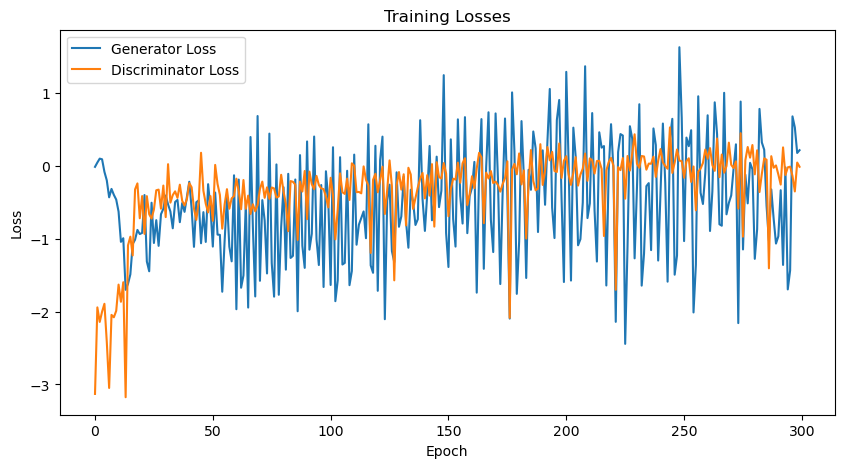

In [ ]:
# Plot loss curves
plt.figure(figsize=(10, 5))
plt.plot(g_losses, label='Generator Loss')
plt.plot(d_losses, label='Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Losses')
# plt.savefig('gan_training_losses.png')
plt.show()
plt.close()


In [10]:
# Generate synthetic data
n_samples = len(real_data_tensor)
print(f"\nGenerating {n_samples} synthetic samples...")

with torch.no_grad():
    z = torch.randn(n_samples, latent_dim)
    synthetic_data_tensor = generator(z)

# Convert back to numpy and denormalize
synthetic_data_np = synthetic_data_tensor.detach().numpy()
synthetic_data_denorm = scaler.inverse_transform(synthetic_data_np)

# Convert to DataFrame with original column names
synthetic_df = pd.DataFrame(synthetic_data_denorm, columns=data.columns)
real_df = data.copy()

# Save synthetic data
synthetic_df.to_csv('synthetic_data.csv', index=False)
print("Synthetic data saved to 'synthetic_data.csv'")


Generating 1199 synthetic samples...
Synthetic data saved to 'synthetic_data.csv'



Plotting feature distributions...


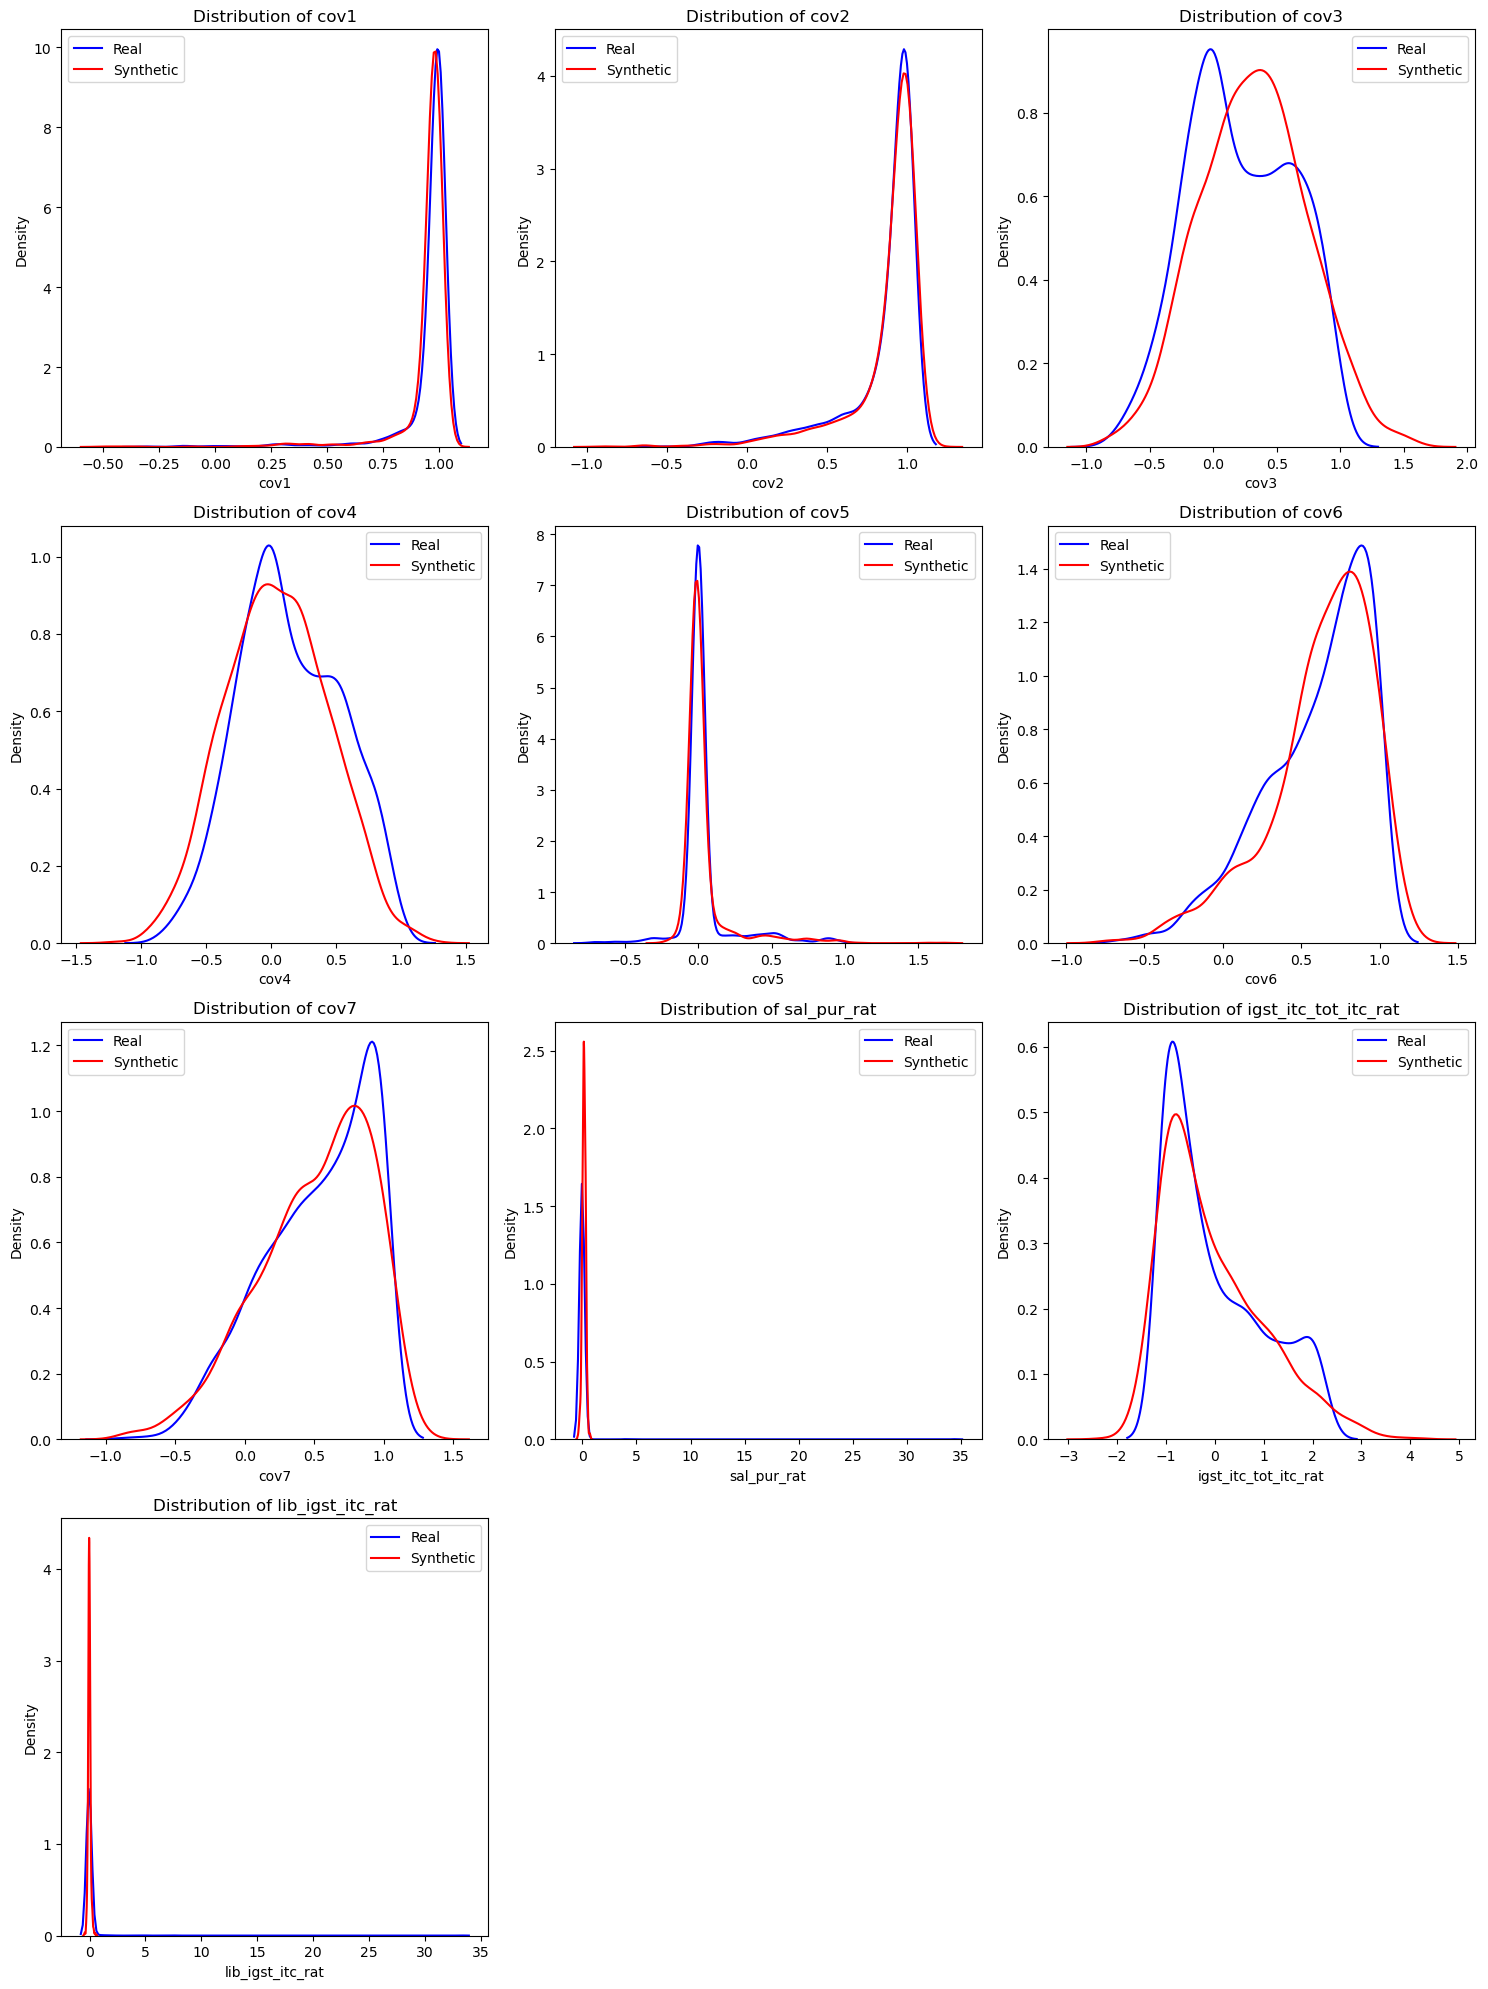

In [ ]:
# Plot distribution comparisons for each feature
print("\nPlotting feature distributions...")
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols
plt.figure(figsize=(15, 5 * n_rows))

for i, feature in enumerate(data.columns):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.kdeplot(real_df[feature], label='Real', color='blue')
    sns.kdeplot(synthetic_df[feature], label='Synthetic', color='red')
    plt.title(f'Distribution of {feature}')
    plt.legend()

plt.tight_layout()
# plt.savefig('feature_distributions.png')
plt.show()
plt.close()


Calculating correlation matrices...


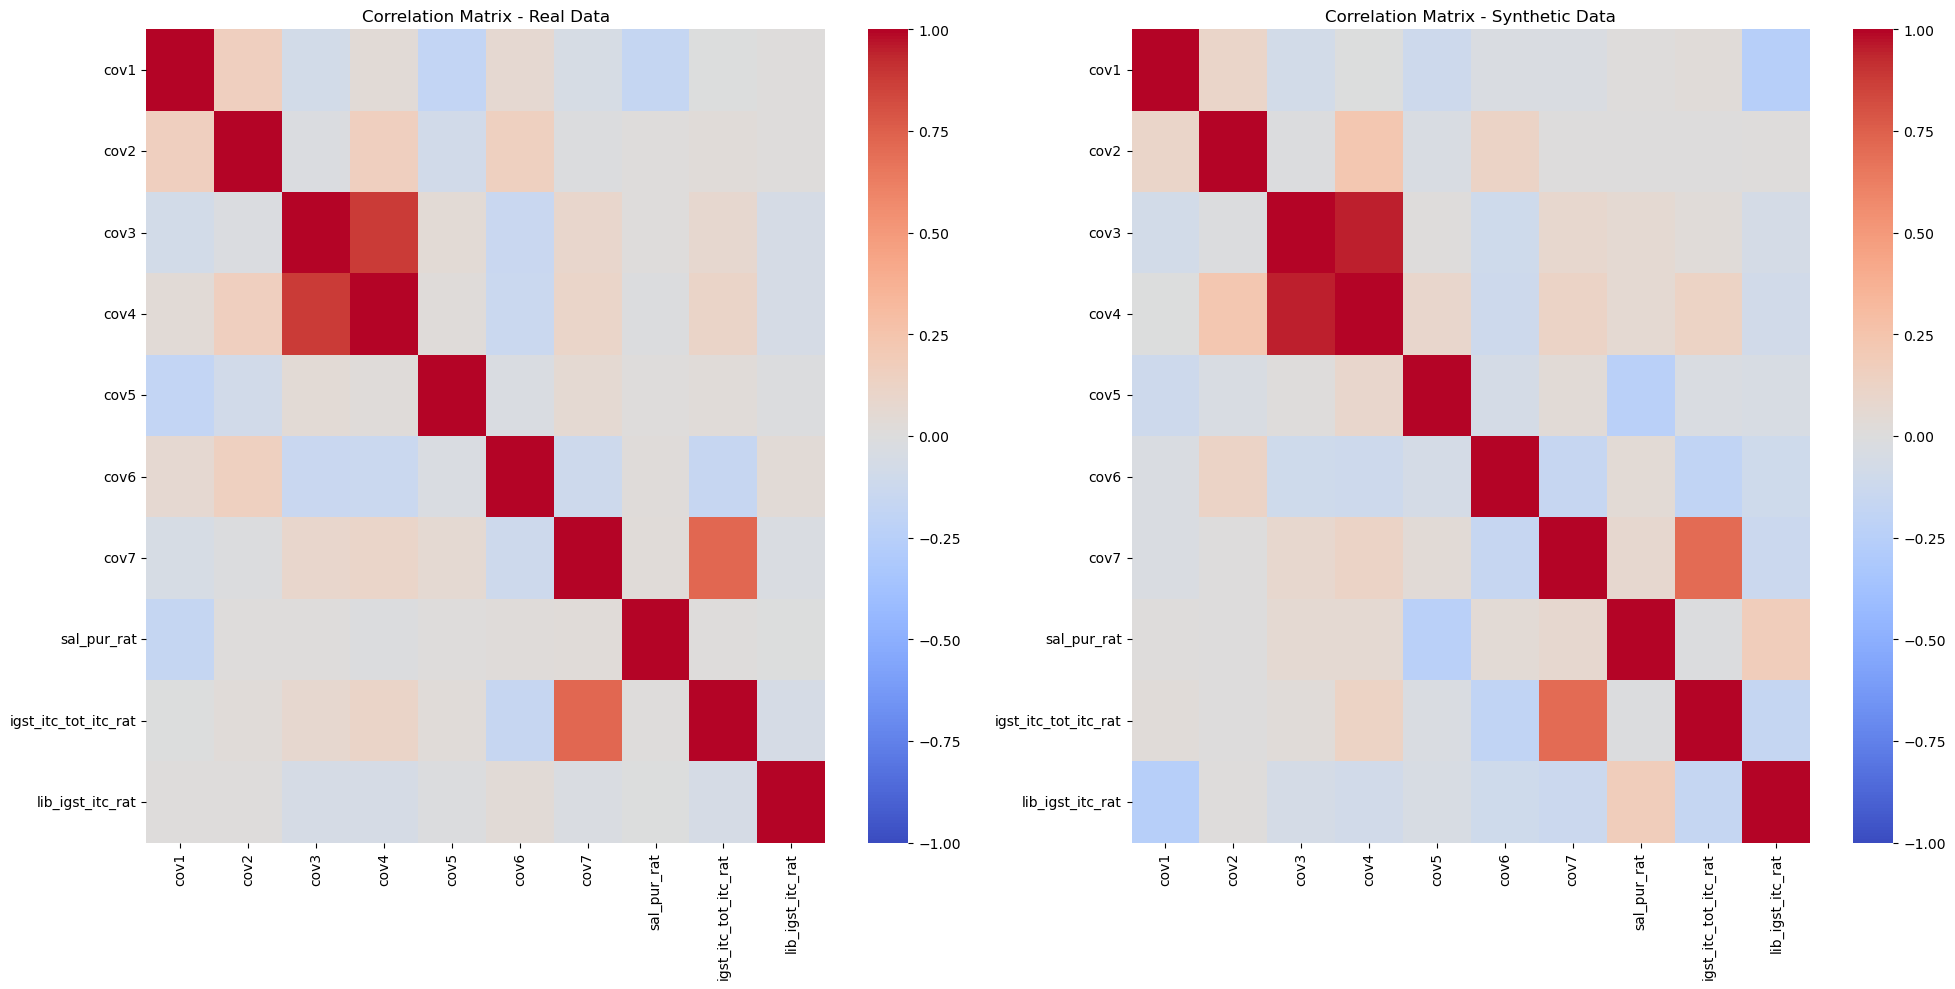


Calculating correlation difference...


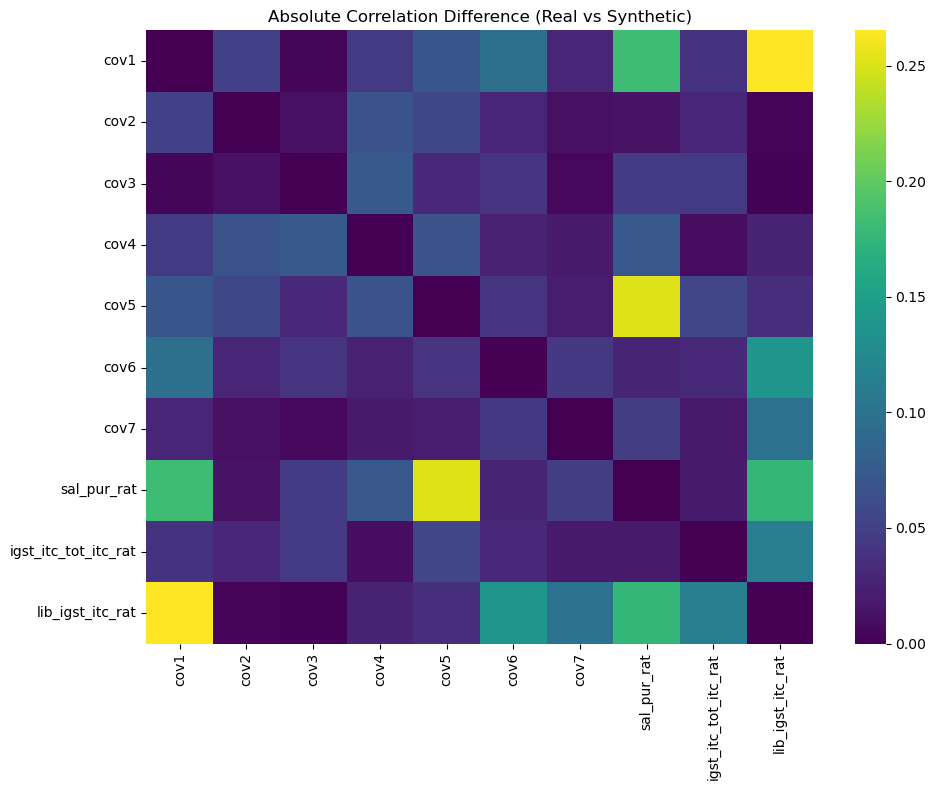

In [ ]:
# Calculating and plot correlation matrices
print("\nCalculating correlation matrices...")
real_corr = real_df.corr()
synthetic_corr = synthetic_df.corr()

plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
sns.heatmap(real_corr, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix - Real Data')

plt.subplot(1, 2, 2)
sns.heatmap(synthetic_corr, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix - Synthetic Data')

plt.tight_layout()
# plt.savefig('correlation_matrices.png')
plt.show()
plt.close()

# Calculating correlation difference
print("\nCalculating correlation difference...")
correlation_diff = abs(real_corr - synthetic_corr)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_diff, annot=False, cmap='viridis')
plt.title('Absolute Correlation Difference (Real vs Synthetic)')
plt.tight_layout()
# plt.savefig('correlation_difference.png')
plt.show()
plt.close()

In [14]:
# Calculating basic statistics for comparison
real_stats = real_df.describe()
synthetic_stats = synthetic_df.describe()

print("\nReal Data Statistics:")
print(real_stats)
print("\nSynthetic Data Statistics:")
print(synthetic_stats)

# Calculating mean absolute error between feature means
mean_mae = np.mean(np.abs(real_stats.loc['mean'] - synthetic_stats.loc['mean']))
std_mae = np.mean(np.abs(real_stats.loc['std'] - synthetic_stats.loc['std']))

print(f"\nMean Absolute Error between means: {mean_mae:.4f}")
print(f"Mean Absolute Error between standard deviations: {std_mae:.4f}")

print("\nSynthetic data generation complete!")


Real Data Statistics:
              cov1         cov2         cov3         cov4         cov5  \
count  1199.000000  1199.000000  1199.000000  1199.000000  1199.000000   
mean      0.956896     0.855770     0.214263     0.147359     0.036329   
std       0.135031     0.244927     0.408193     0.388080     0.177615   
min      -0.312219    -0.531958    -0.818128    -0.839158    -0.719622   
25%       0.982505     0.840675    -0.095193    -0.143054     0.000000   
50%       0.999235     0.969806     0.175910     0.097584     0.000000   
75%       0.999993     0.996604     0.563061     0.457633     0.000000   
max       1.000000     1.000000     1.000000     0.979015     0.999196   

              cov6         cov7   sal_pur_rat  igst_itc_tot_itc_rat  \
count  1199.000000  1199.000000  1.199000e+03          1.199000e+03   
mean      0.599809     0.527768 -1.251042e-11         -5.004165e-12   
std       0.334306     0.385322  1.000000e+00          1.000000e+00   
min      -0.682734    -0.8

# result is saved in synthetic_data.csv